Wczytywanie obrazu indeksu

In [ ]:
from typing import List, Tuple
from cv2 import imread, threshold, THRESH_BINARY_INV

# img = imread("../data/test/numbers2.jpg", 0)
# ret, bw = threshold(img, 127, 255, THRESH_BINARY_INV)
from matplotlib import pyplot as plt

img_list = []
for i in range(30):
    img_list.append(imread(f"../data/test/numbers{i}.png", 0))

Przycinanie cyfr za pomocą OPTICS

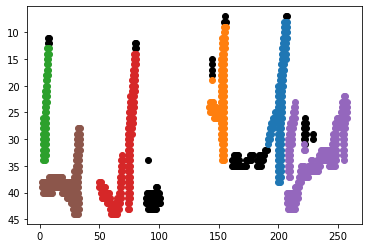

Groups count: 6
Min points in group: 58
Mean points in group: 143.83333333333334


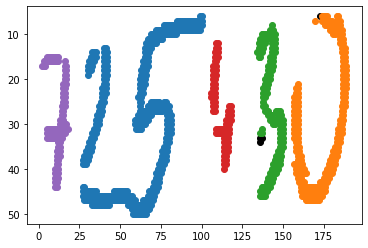

Groups count: 5
Min points in group: 91
Mean points in group: 234


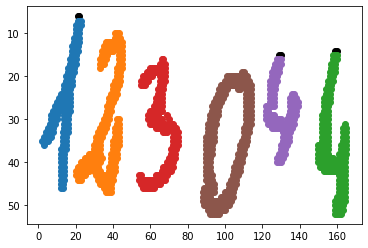

Groups count: 6
Min points in group: 150
Mean points in group: 221.66666666666666


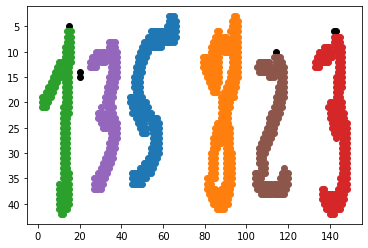

Groups count: 6
Min points in group: 171
Mean points in group: 213.83333333333334


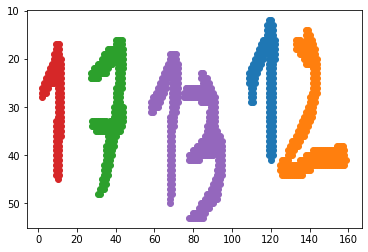

Groups count: 5
Min points in group: 124
Mean points in group: 222.4


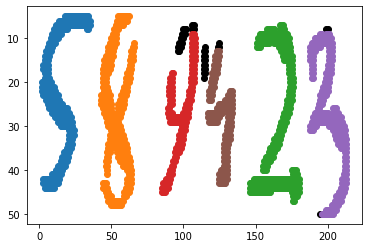

Groups count: 6
Min points in group: 159
Mean points in group: 267.8333333333333


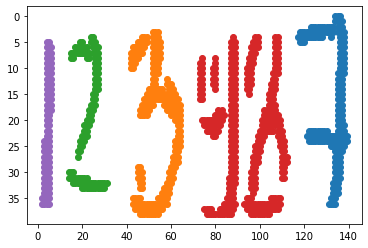

Groups count: 5
Min points in group: 92
Mean points in group: 210.8


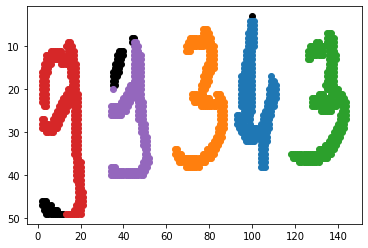

Groups count: 5
Min points in group: 177
Mean points in group: 223.2


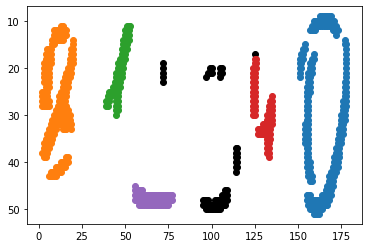

Groups count: 5
Min points in group: 68
Mean points in group: 140.6


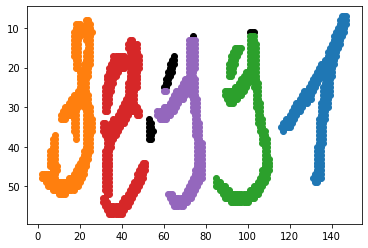

Groups count: 5
Min points in group: 228
Mean points in group: 276


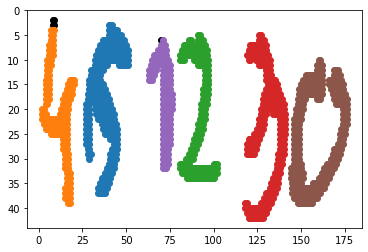

Groups count: 6
Min points in group: 150
Mean points in group: 250.83333333333334


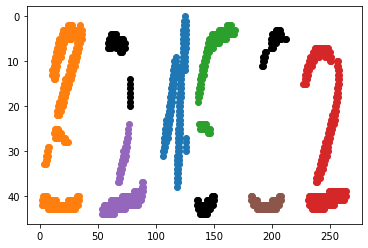

Groups count: 6
Min points in group: 60
Mean points in group: 179.66666666666666


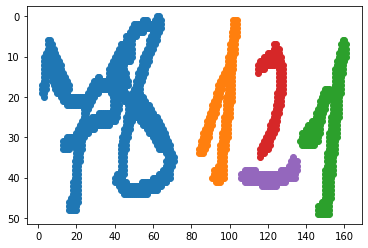

Groups count: 5
Min points in group: 113
Mean points in group: 337.8


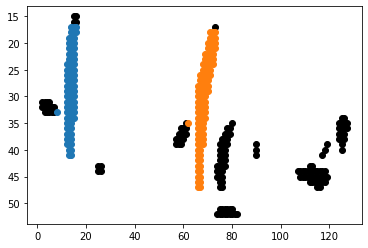

Groups count: 2
Min points in group: 85
Mean points in group: 93.5


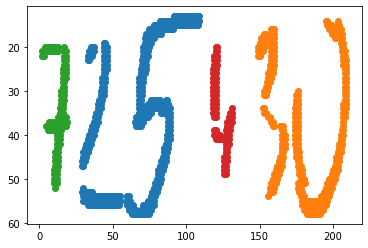

Groups count: 4
Min points in group: 104
Mean points in group: 295


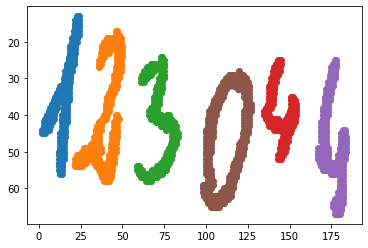

Groups count: 6
Min points in group: 175
Mean points in group: 254.66666666666666


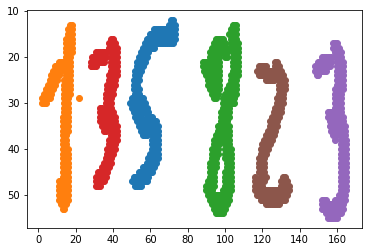

Groups count: 6
Min points in group: 188
Mean points in group: 241.5


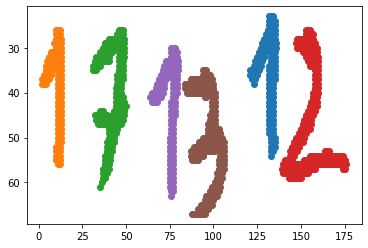

Groups count: 6
Min points in group: 135
Mean points in group: 202.83333333333334


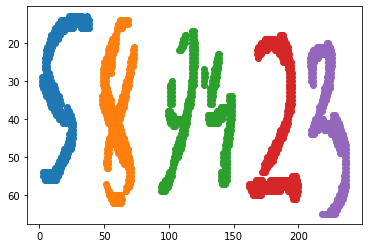

Groups count: 5
Min points in group: 306
Mean points in group: 360.8


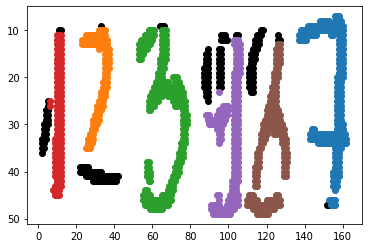

Groups count: 6
Min points in group: 108
Mean points in group: 185.66666666666666


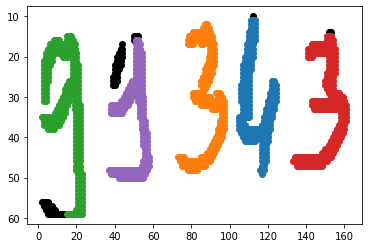

Groups count: 5
Min points in group: 211
Mean points in group: 249


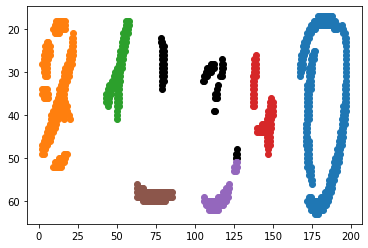

Groups count: 6
Min points in group: 57
Mean points in group: 135.33333333333334


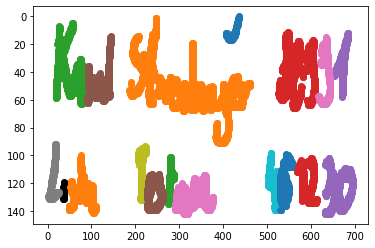

Groups count: 17
Min points in group: 100
Mean points in group: 564.3529411764706


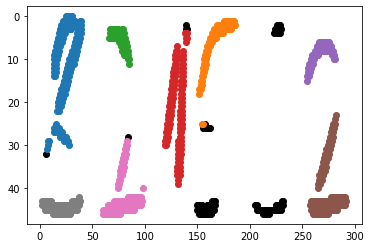

Groups count: 8
Min points in group: 58
Mean points in group: 132.625


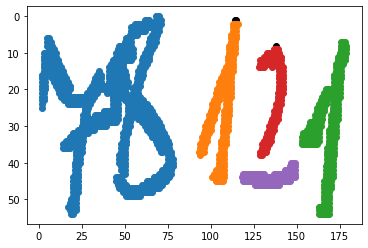

Groups count: 5
Min points in group: 115
Mean points in group: 381


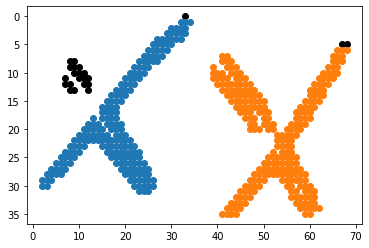

Groups count: 2
Min points in group: 203
Mean points in group: 228.5


KeyboardInterrupt: 

In [ ]:
import numpy as np


def segment_to_digits(segment: np.array, verbose: int = 0) -> List[np.array]:
    from sklearn.cluster import OPTICS
    from statistics import mean

    nonzero_y, nonzero_x = np.where(segment > 0)
    nonzero_points = np.array(list(zip(nonzero_x, nonzero_y)))

    clt = OPTICS(min_samples=15,
                 max_eps=6,
                 xi=0.8,
                 min_cluster_size=50)

    try:
        clt.fit(nonzero_points)
    except Exception:
        return []

    labels = np.unique(clt.labels_)

    if labels.shape[0] < 6:
        clt.max_eps = 4
        clt.fit(nonzero_points)
        labels = np.unique(clt.labels_)
    elif labels.shape[0] > 6:
        clt.max_eps = 8
        clt.fit(nonzero_points)
        labels = np.unique(clt.labels_)

    outliers = []
    digits_coord = []
    digits_points = []
    for label in labels:
        points = nonzero_points[np.where(clt.labels_ == label)]

        if label == -1:
            outliers = points
            continue

        if verbose >= 1:
            digits_points.append(points)

        digits_coord.append((min(points[:, 1]), max(points[:, 1] + 1), min(points[:, 0]), max(points[:, 0]) + 1))

    if verbose >= 1:
        if len(outliers) > 2:
            plt.scatter(outliers[:, 0], outliers[:, 1], c='black')

        for points in digits_points:
            plt.scatter(points[:, 0], points[:, 1])
        plt.gca().invert_yaxis()
        plt.show()

        if verbose >= 2:
            print("Groups count:", len(digits_points))
            print("Min points in group:", min(g.shape[0] for g in digits_points))
            print("Mean points in group:", mean(g.shape[0] for g in digits_points))

    digits_coord.sort(key=lambda x: x[2])

    digits = []
    for d in digits_coord:
        digits.append(segment[d[0]:d[1], d[2]:d[3]])

    return digits


img_digits = []
for img in img_list:
    img_digits.append(segment_to_digits(img, 2))


Upodobnienie obrazów cyfr do obrazów ze zbioru MNIST.

In [ ]:
def digits_to_mnist_format(digits: List[np.array]) -> None:
    from cv2 import resize, INTER_AREA, copyMakeBorder, BORDER_CONSTANT, dilate
    import math

    for i in range(len(digits)):
        d = digits[i]

        d_height, d_width = d.shape

        sample_size = 28
        border_size = 4
        max_size = sample_size - (border_size * 2)

        if d_width > d_height:
            d_proportion = d_height / d_width
            scaled_dim = max(1, int(max_size * d_proportion))
            d = resize(d, (max_size, scaled_dim), interpolation=INTER_AREA)
        else:
            d_proportion = d_width / d_height
            scaled_dim = max(1, int(max_size * d_proportion))
            d = resize(d, (scaled_dim, max_size), interpolation=INTER_AREA)

        border_v = (sample_size - d.shape[0]) / 2
        border_v_T = math.ceil(border_v)
        border_v_B = math.floor(border_v)

        border_h = (sample_size - d.shape[1]) / 2
        border_h_L = math.ceil(border_h)
        border_h_R = math.floor(border_h)

        d = copyMakeBorder(d, border_v_T, border_v_B, border_h_L, border_h_R, BORDER_CONSTANT)

        kernel = np.ones((2, 2), np.uint8)
        d = dilate(d, kernel, iterations=1)

        digits[i] = d


for digits in img_digits:
    digits_to_mnist_format(digits)

Uczenie klasyfikatora SVM na zbiorze danych MNIST.
(Alternatywnie, wczytanie go z pliku)

In [ ]:
def load_clf_and_dataset(clf_pickle_path: str):
    import os
    import pickle
    from sklearn.datasets import fetch_openml
    from sklearn.svm import SVC

    if not os.path.isfile(clf_pickle_path):
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

        clf = SVC().fit(X, y)

        with open(clf_pickle_path, 'wb') as f:
            pickle.dump(clf, f)
    else:
        with open(clf_pickle_path, 'rb') as f:
            clf = pickle.load(f)

    return clf


clf_pickle_path = "../pickled_objects/clf_mnist.pickle"
clf = load_clf_and_dataset(clf_pickle_path)

Podgląd przetworzonych cyfr oraz cyfr ze zbioru mnist

In [ ]:
def predict_digits(clf, digits: List[np.array]) -> np.array:
    if digits == []:
        return []
    reshaped = np.array([d.reshape(784) for d in digits])
    return clf.predict(reshaped)


for i in range(len(img_digits)):
    plt.imshow(img_list[i])
    plt.show()
    print(predict_digits(clf, img_digits[i]))